In [145]:
cd ..

/Users/hao/workspace/hpi_de/4th_Semester/Online Learning/rl-4-self-repair


In [6]:
import time
import tensorflow as tf
#from tensorflow.keras import backend as K
#from tensorflow.keras.layers import Dense, Input
#from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from IPython.display import clear_output
import seaborn as sns
tf.config.experimental_run_functions_eagerly(True)

import gym
import numpy as np
from envs.broken_components import BrokenComponentsEnv
from envs.data_handler import DataHandler

Using TensorFlow backend.


ModuleNotFoundError: No module named 'envs'

In [3]:
class A2C():
    def __init__(self, alpha, beta, gamma=0.99, n_actions=4, layer1_size=1024, layer2_size=512, input_dims=8):
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.input_dims = input_dims
        self.fc1_dims = layer1_size
        self.fc2_dims = layer2_size
        self.n_actions = n_actions
        
        self.actor, self.critic, self.policy = self.build_actor_critic_network()
        self.action_space = [i for i in range(self.n_actions)]
       
    
    def build_actor_critic_network(self):
        input = Input(shape=(self.input_dims, ))
        delta = Input(shape=[1])
        dense1 = Dense(self.fc1_dims, activation='relu')(input)
        dense2 = Dense(self.fc2_dims, activation='relu')(dense1)
        
        probs = Dense(self.n_actions, activation='softmax')(dense2)
        values = Dense(1, activation='linear')(dense2)
        
        def custom_loss(y_true, y_pred):
            out = K.clip(y_pred, 1e-8, 1-1e-8)
            log_like = y_true*K.log(out)
            
            return K.sum(-log_like*delta)
        
        actor = Model(inputs=[input, delta], outputs=[probs])
        actor.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss)
        
        critic = Model(inputs=[input], outputs=[values])
        critic.compile(optimizer=Adam(lr=self.beta), loss='mean_squared_error')
        
        policy = Model(inputs=[input], outputs=[probs])
        
        return actor, critic, policy
    
    def choose_action(self, observation):
        state = observation[np.newaxis, :]
        probabilities = self.policy.predict(state)[0]
        action = np.random.choice(self.action_space, p=probabilities)
        
        return action
    
    def learn(self, state, action, reward, state_, done):
        state = state[np.newaxis, :]
        state_ = state_[np.newaxis, :]
        
        critic_value_ = self.critic.predict(state_)
        critic_value = self.critic.predict(state)
        
        target = reward + self.gamma*critic_value_*(1-int(done))
        delta = target - critic_value
        
        actions = np.zeros([1, self.n_actions])
        actions[np.arange(1), action] = 1.0
        
        self.actor.fit([state, delta], actions, verbose=0)
        self.critic.fit(state, target, verbose=0)

In [4]:
dh = DataHandler()
broken_components = dh.get_sample_component_failure_pairs(5)
broken_components

[('_SE8XfecdEeet0YmmfbMwkw', 'CF1'),
 ('_SFB3TOcdEeet0YmmfbMwkw', 'CF3'),
 ('_SFS9IOcdEeet0YmmfbMwkw', 'CF3'),
 ('_SFB2pucdEeet0YmmfbMwkw', 'CF3'),
 ('_SFJLAucdEeet0YmmfbMwkw', 'CF1')]

In [5]:
env = BrokenComponentsEnv(broken_components, reward_modus='raw', reward_decrease=True, reward_decrease_factor=0.99)

In [18]:
agent = A2C(alpha=0.00001, beta=0.00005, n_actions=env.action_space.n, input_dims=len(env.masks[0]), layer1_size=1024, layer2_size=512)

score_history = []
num_episodes = 2000

avg_score = 0
for i in range(num_episodes):
    done = False
    score = 0
    observation = env.reset()
    clear_output(wait=True)
    env.render()
    while not done:
        action = agent.choose_action(env.masks[observation].astype(float))
        #action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        clear_output(wait=True)
        env.render()
        print('episode ', i, ': score %.2f | average score %.2f' % (score, avg_score))
        agent.learn(env.masks[observation].astype(float), action, reward, env.masks[observation_].astype(float), done)
        #agent.learn(observation, action, reward, observation_, done)
        
        observation = observation_
        score += reward
    
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    #print('episode ', i, ': score %.2f | average score %.2f' % (score, avg_score))
    #time.sleep(3)

Steps:  5
Action:  ('_SE8XfecdEeet0YmmfbMwkw', 'CF1')
Successful:  True
State:  [] 


episode  1999 : score 80.73 | average score 87.26


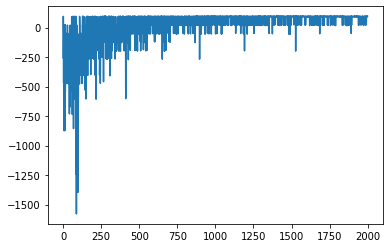

In [19]:
sns.lineplot(np.arange(len(score_history)), score_history)

In [20]:
avg_score = np.mean(np.array(score_history).reshape(-1, 100), axis=1)

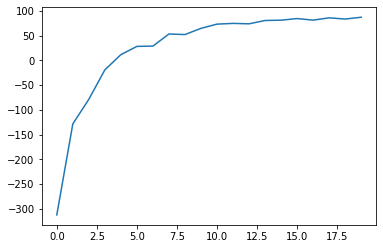

In [21]:
sns.lineplot(np.arange(len(avg_score)), avg_score)

## CartPole

In [22]:
env = gym.make('CartPole-v1')

In [23]:
agent1 = A2C(alpha=0.0001, beta=0.0005, n_actions=env.action_space.n, input_dims=env.observation_space.sample().shape[0], layer1_size=1024, layer2_size=512)

score_history2 = []
num_episodes = 1000

for i in range(num_episodes):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        action = agent1.choose_action(observation)
        observation_, reward, done, info = env.step(action)

        agent1.learn(observation, action, reward, observation_, done)
        
        observation = observation_
        score += reward
    
    score_history2.append(score)
    avg_score = np.mean(score_history2[-100:])
    print('episode ', i, ': score %.2f | average score %.2f' % (score, avg_score))

episode  0 : score 10.00 | average score 10.00
episode  1 : score 15.00 | average score 12.50
episode  2 : score 21.00 | average score 15.33
episode  3 : score 16.00 | average score 15.50
episode  4 : score 9.00 | average score 14.20
episode  5 : score 9.00 | average score 13.33
episode  6 : score 9.00 | average score 12.71
episode  7 : score 10.00 | average score 12.38
episode  8 : score 9.00 | average score 12.00
episode  9 : score 9.00 | average score 11.70
episode  10 : score 10.00 | average score 11.55
episode  11 : score 8.00 | average score 11.25
episode  12 : score 8.00 | average score 11.00
episode  13 : score 11.00 | average score 11.00
episode  14 : score 11.00 | average score 11.00
episode  15 : score 10.00 | average score 10.94
episode  16 : score 9.00 | average score 10.82
episode  17 : score 8.00 | average score 10.67
episode  18 : score 12.00 | average score 10.74
episode  19 : score 23.00 | average score 11.35
episode  20 : score 10.00 | average score 11.29
episode  21

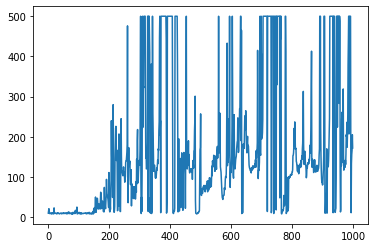

In [24]:
sns.lineplot(np.arange(len(score_history2)), score_history2)

In [25]:
avg_score = np.mean(np.array(score_history2).reshape(-1, 100), axis=1)

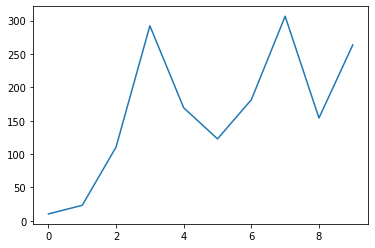

In [26]:
sns.lineplot(np.arange(len(avg_score)), avg_score)

In [372]:
ts = 20
a = 55
b = 0.5
c = 250

In [373]:
# logistic growth
import math
def my_logistic(t, a, b, c):
    return c / (1 +  a * np.exp(-b*t))

In [374]:
vals = []
for t in range(ts):
    vals.append(int(my_logistic(t,a ,b, c)))

In [375]:
#vals = np.linspace(0, 201, 20).astype(int)

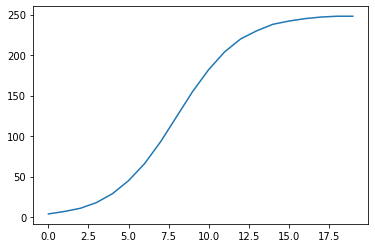

In [376]:
sns.lineplot(np.arange(ts), vals)

In [377]:
vals

[4,
 7,
 11,
 18,
 29,
 45,
 66,
 93,
 124,
 155,
 182,
 204,
 220,
 230,
 238,
 242,
 245,
 247,
 248,
 248]

In [1]:
cd ..

/Users/hao/workspace/hpi_de/4th_Semester/Online Learning/rl-4-self-repair


In [4]:
from envs.broken_components import BrokenComponentsEnv
from envs.data_handler import DataHandler

preparedData_Linear.csv


In [5]:
dh = DataHandler()

preparedData_Linear.csv


In [6]:
component_nums = [4,
 7,
 11,
 18,
 29,
 45,
 66,
 93,
 124,
 155,
 182,
 204,
 220,
 230,
 238,
 242,
 245,
 247,
 248,
 250]

In [15]:
dh = DataHandler()
seed = 42
broken_components_array = []
for component_num in component_nums:
    broken_components_array.append(dh.get_sample_component_failure_pairs(component_num, seed))

preparedData_Linear.csv


In [16]:
broken_components_array

[[('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBPiOcdEeet0YmmfbMwkw', 'CF2'),
  ('_SFFhCOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFLBrucdEeet0YmmfbMwkw', 'CF3')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBPiOcdEeet0YmmfbMwkw', 'CF2'),
  ('_SFFhCOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFLBrucdEeet0YmmfbMwkw', 'CF3'),
  ('_SFKZ0ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFGwm-cdEeet0YmmfbMwkw', 'CF3'),
  ('_SE-zPOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFJzc-cdEeet0YmmfbMwkw', 'CF1')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBP

In [9]:
broken_components_array

[[('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBPiOcdEeet0YmmfbMwkw', 'CF2'),
  ('_SFFhCOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFLBrucdEeet0YmmfbMwkw', 'CF3')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBPiOcdEeet0YmmfbMwkw', 'CF2'),
  ('_SFFhCOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFLBrucdEeet0YmmfbMwkw', 'CF3'),
  ('_SFKZ0ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFGwm-cdEeet0YmmfbMwkw', 'CF3'),
  ('_SE-zPOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFJzc-cdEeet0YmmfbMwkw', 'CF1')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBP

In [2]:
from algorithm_analysis.benchmark import BROKEN_COMPONENTS_LIST

In [3]:
BROKEN_COMPONENTS_LIST

[[('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBPiOcdEeet0YmmfbMwkw', 'CF2'),
  ('_SFFhCOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFLBrucdEeet0YmmfbMwkw', 'CF3')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBPiOcdEeet0YmmfbMwkw', 'CF2'),
  ('_SFFhCOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFLBrucdEeet0YmmfbMwkw', 'CF3'),
  ('_SFKZ0ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFGwm-cdEeet0YmmfbMwkw', 'CF3'),
  ('_SE-zPOcdEeet0YmmfbMwkw', 'CF1'),
  ('_SFJzc-cdEeet0YmmfbMwkw', 'CF1')],
 [('_SFCdz-cdEeet0YmmfbMwkw', 'CF2'),
  ('_SFS91ecdEeet0YmmfbMwkw', 'CF2'),
  ('_SFB3ZucdEeet0YmmfbMwkw', 'CF2'),
  ('_SFBPfOcdEeet0YmmfbMwkw', 'CF3'),
  ('_SFBP